# Hi Adam!
Super quick question for you. I know it's a pain in the ass to be tech support for so many people, but I'm guessing you'll know what my issue is...

### Note: I am using pyspeckit version 0.1.19, installed via 'pip install pyspeckit', on an up-to-date Py2.7 Anaconda stack. 

### About the data

I'm merely trying to find a redshift, fit linewidths, get fluxes, etc. for this simple LBT  optical spectrum of a nearby CSS radio source. I used to do this in IRAF, but I'm trying to get better at PySpecKit (which is awesome, btw). 

I've copy/pasted info about the data below, but it's not really important: 

In this directory you'll find

* A reduced 1D spectrum that has been flux calibrated and corrected for heliocentric velocity
* The same 1D spectrum that has also been de-reddened for galactic extinction, using $R_V=3.1$ and $A_V=0.129$,  based on Schlafly and Finkbeiner values in NED.

This optical spectrum, running from 0.38-0.928 microns, was obtained with the Large Binocular Telescope on 11 January 2017. The instrument used was MODS-2 in dual grating mode.  Only one mirror (DX or right side) was used, so you only got 1 x 8.4m. The target, low in elevation, was observed for 1200 seconds at an average airmass of $\sim2.4$. The slit width was 1.2", and the average seeing was 2" throughout the observation. We used a 2" diameter extraction aperture along the spatial axis.  However, since the slitwidth was smaller than this (1.2"), the actual spectral resolution is 7 angstroms (I measured 3.5 angstroms in the red using a 0.6" slitwidth and the arc lamps. Since it scales, then it will be a spectral resolution of 7 angstroms).  We might want resample from 0.85 ang/pixel to 7 ang/pixel. 

Final spectra runs from 0.38-0.928microns.

The Galactic extinction correction is Rv=3.1 and Av=0.129 based on Schlafly and Finkbeiner values in NED.




### Setup

In [1]:
import sys
import os
import glob

import numpy as np

from astropy.io import fits
from astropy.io import ascii
from astropy.table import QTable

from astropy.cosmology import FlatLambdaCDM

import astropy.units as u

import pyspeckit

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

Make a Cosmology

In [2]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

Make plots pretty

In [3]:
plt.rcParams.update({'font.size'     : 12,
                    'axes.labelsize' : 12,
                    'legend.fontsize': 12,
                    'xtick.labelsize': 12,
                    'ytick.labelsize': 12,
                    'axes.linewidth' :  1.5  })
style.use('ggplot')

### Initial Exploration of the Data

In [4]:
os.listdir('.')

['.git',
 '.ipynb_checkpoints',
 'ipython_log_2017-02-01.py',
 'PKS1017-325_error_heliocorrect_galextinct.fits',
 'PKS1017-325_heliocorrect_galextinct.fits',
 'PKS1017_Analysis.ipynb']

In [5]:
datafile = fits.open('PKS1017-325_heliocorrect_galextinct.fits')

In [6]:
datafile.info()

Filename: PKS1017-325_heliocorrect_galextinct.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     287   (6453,)   float32   


In [7]:
datafile[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =                 6453 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2017-01-21T08:38:04' / Date FITS file was generated                  
IRAF-TLM= '2017-01-21T08:38:04' / Time of last modification                     
OBJECT  = 'PKS1017-325 - Aperture 1' / Name of the object observed              
BUNIT   = 'erg/cm2/s/A'        / units of physical values (LBT)                 
COMMENT  Detector Information                                                   
DETECTOR= 'e2v CCD231-68 Blue CCD 2'     / Detector name                        
DETSIZE = '[1:8288,1:3088]' 

### Populate the Wavelength, Flux, and Error Arrays


The wavelength will go as

```python
wavelength = ((np.arange(N) + 1.0) - CRPIX1) * CD1_1 + CRVAL1 ```

In [8]:
n = len(datafile[0].data)
crpix1 = datafile[0].header['CRPIX1']
crval1 = datafile[0].header['CRVAL1']
cd1_1 = datafile[0].header['CD1_1'] # The data have been resampled to 0.85 angstroms / pixel

In [9]:
wavelength = ((np.arange(n) + 1.0) - crpix1) * cd1_1 + crval1

Check that this is correct: 

In [10]:
wavelength

array([ 3800.26086938,  3801.11092774,  3801.96098609, ...,  9283.13724212,
        9283.98730047,  9284.83735882])

In [11]:
if n == len(wavelength):
    print("Wavelength and Flux arrays match")
else: 
    print("Warning! Something is wrong with the Wavelength array")

Wavelength and Flux arrays match


Yup. Now for the flux: 

In [12]:
flux = datafile[0].data

In [13]:
datafile[0].header["BUNIT"]

'erg/cm2/s/A'

Now for the Error: 

In [14]:
errorfile = fits.open('PKS1017-325_error_heliocorrect_galextinct.fits')

In [15]:
error = errorfile[0].data

Let's quickly check that this looks good: 

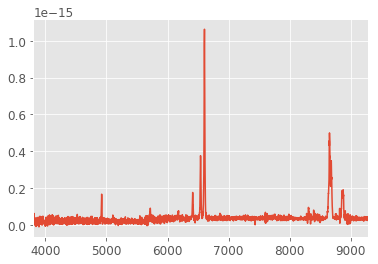

In [16]:
fig, ax = plt.subplots()
ax.set_xlim(3800, 9284)

plt.plot(wavelength, flux)
plt.show()

### Build a PySpecKit Spectrum

In [17]:
sp = pyspeckit.Spectrum(data=flux, xarr=wavelength, error=error, unit='erg/s/cm^2/AA', xarrkwargs={'unit':'AA'},header=datafile[0].header)

'erg/cm2/s/A' contains multiple slashes, which is discouraged by the FITS standard


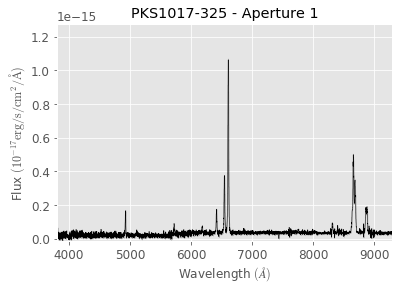

In [18]:
sp.plotter(errstyle='fill')
sp.plotter.axis.set_xlabel(r'Wavelength $(\AA)$')
sp.plotter.axis.set_ylabel(r'Flux $(10^{-17} \mathrm{erg/s/cm^2/\AA})$')
sp.plotter.refresh()

### Initial Redshift Guess

#### The redshift of the source is about 0.3186. 
I know this because the lines were trivially identifiable by the spectrum. By eye, the [O III] 5007 line peak was at 6602 \AA, corresponding to a (1+z) of (6602 / 5007) = 1.3186 (i.e., a z of 0.3186).

We'll fit the [O III] and H$\beta$ region, which is nice and clean and good for a redshift. Let's zoom in on it: 

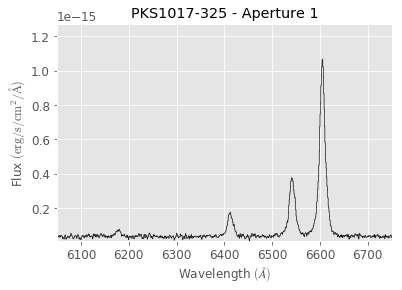

In [19]:
sp.plotter(xmin=6050, xmax=6750, errstyle='fill')
sp.plotter.axis.set_xlabel(r'Wavelength $(\AA)$')
sp.plotter.axis.set_ylabel(r'Flux $(\mathrm{erg/s/cm^2/\AA})$')
sp.plotter.refresh()

Set rest wavelengths of the lines we know we're fitting: 

In [20]:
# Clear line detections in this window, from blue to red: 

o3region_linewavs = {'HeII' : 4685.7,  
                     'Hbeta' : 4861.34, 
                     'OIII4959' :4958.9,
                     'OIII5007' : 5006.8
                    }

By eye, I know the redshift is about z=0.31868

In [21]:
z_guess = 0.31868
z_guess_factor = (1 + z_guess)

I also know that the Gaussian FWHM of each of these four lines is about 15 angstroms

In [22]:
fwhm_guess = 15.

# I just quickly estimated this in IRAF SPLOT.
# I could also estimate this in python, with 
# width_guess = data.sum() / amplitude_guess / np.sqrt(2*np.pi)

Let's estimate line amplitudes, and also make a dictionary of our redshifted lines (assuming our z_guess_factor)

In [23]:
o3region_amplitudes = {}
for line in o3region_linewavs:
    sp.specfit.selectregion(xmin = o3region_linewavs[line] *z_guess_factor - 30, xmax = o3region_linewavs[line]*z_guess_factor + 30)
    amp = np.max(sp.data[sp.specfit.xmin:sp.specfit.xmax])
    d = {line : amp}
    o3region_amplitudes.update(d)
    
o3region_redshifted_lines = {}
for line in o3region_linewavs:
    redline = o3region_linewavs[line] * z_guess_factor
    d = {line : redline}
    o3region_redshifted_lines.update(d)    


#### Make an inititial fit with guesses

Guesses should be constructed as: 

```python
guesses = [ AMPLITUDE_GUESS, CENTER_GUESS, WIDTH_GUESS,
            AMPLITUDE_GUESS, CENTER_GUESS, WIDTH_GUESS,]
```
and so on. One line for each gaussian you want to fit. Guesses should take the format of: 

```python
guesses = [amplitude_guess, center_guess, width_guess]
```
Multiple components are strung along in one list, e.g. 
```python
guesses = [amplitude, center, width,            # where this is [amp, center, width] of Gaussian 1
           amplitude, center, width,            # ... guassian 2
           amplitude, center, width]            # ... gaussian 3 (and so on...)
```

In [24]:
guesses = []
for line in o3region_linewavs:
    guess = [o3region_amplitudes[line], o3region_redshifted_lines[line], fwhm_guess]
    guesses += guess
    
guesses = tuple(guesses) # make sure the 'guesses' variable is *NOT* writeable
guesses

(7.6285825e-17,
 6178.938876,
 15.0,
 1.0626776e-15,
 6602.367024000001,
 15.0,
 3.7520897e-16,
 6539.202252,
 15.0,
 1.7534279e-16,
 6410.5518312,
 15.0)

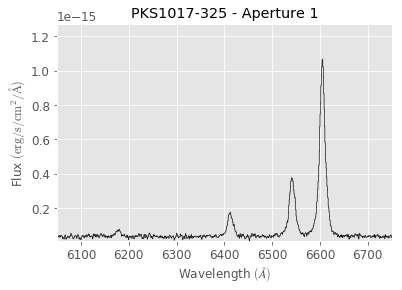

In [25]:
sp.plotter(xmin=6050, xmax=6750, errstyle='fill')
sp.plotter.axis.set_xlabel(r'Wavelength $(\AA)$')
sp.plotter.axis.set_ylabel(r'Flux $(\mathrm{erg/s/cm^2/\AA})$')
sp.plotter.refresh()

Make a baseline, just for the hell of it. 

In [26]:
linemask = []
for line in o3region_linewavs:
    xmin = o3region_linewavs[line] - 30.0
    xmax = o3region_linewavs[line] + 30.0
    mask = [xmin, xmax]
    linemask += mask
    
linemask

[4655.7, 4715.7, 4976.8, 5036.8, 4928.9, 4988.9, 4831.34, 4891.34]

In [27]:
#sp.baseline(xmin=6050, xmax=6750, exclude=linemask, subtract=False, reset_selection=False, highlight_fitregion=True, order=2)

# Here's where my problem lies - the fit doesn't work! Do you know what I've done wrong? 

INFO: Renormalizing data by factor 3.248316e-17 to improve fitting procedure [pyspeckit.spectrum.fitters]


(-1e-16, 2e-15)

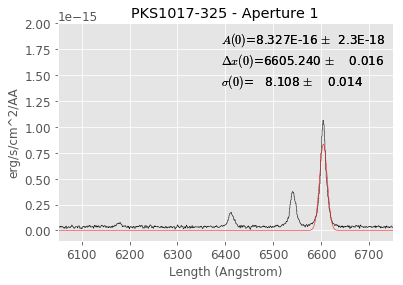

In [28]:
sp.plotter()
sp.specfit(guesses=[1e-16,6603,5])
sp.plotter.axis.set_ylim(-1e-16, 2e-15)

In [39]:
print(guesses), len(guesses), len(guesses)/3

(7.6285825e-17, 6178.938876, 15.0, 1.0626776e-15, 6602.367024000001, 15.0, 3.7520897e-16, 6539.202252, 15.0, 1.7534279e-16, 6410.5518312, 15.0)


(None, 12, 4.0)

In [40]:
sp.error

masked_array(data = [  3.82400179e-18   4.39784800e-18   4.39897586e-18 ...,   2.48575260e-18
   2.34658753e-18   2.28623602e-18],
             mask = False,
       fill_value = 1e+20)

In [41]:
#from astropy import log
#log.setLevel('DEBUG')

In [42]:
for par in sp.specfit.parinfo:
    print(par.scaleable, par)

True Param #0   AMPLITUDE0 =  3.88743e-17 +/-     4.91062e-20 
False Param #1       SHIFT0 =      8641.02 +/-         19.3875 
False Param #2       WIDTH0 =      3440.59 +/-         18.1573   Range:   [0,inf)
True Param #3   AMPLITUDE1 =  8.78128e-16 +/-     2.53426e-18 
False Param #4       SHIFT1 =      6605.18 +/-       0.0165556 
False Param #5       WIDTH1 =      7.07738 +/-       0.0133443   Range:   [0,inf)
True Param #6   AMPLITUDE2 =   3.1287e-16 +/-     1.50807e-18 
False Param #7       SHIFT2 =      6541.84 +/-       0.0301744 
False Param #8       WIDTH2 =      6.97481 +/-       0.0261652   Range:   [0,inf)
True Param #9   AMPLITUDE3 =  1.31166e-16 +/-     1.04137e-18 
False Param #10       SHIFT3 =      6412.47 +/-       0.0502355 
False Param #11       WIDTH3 =      6.38373 +/-       0.0463755   Range:   [0,inf)


In [45]:
guesses = [1e-16,9999,15]*4
guesses[1] = 6178
guesses[4] = 6541
guesses[7] = 6410
guesses[10] = 6605

In [55]:
import copy
from astropy import log

INFO: Renormalizing data by factor 3.248316e-17 to improve fitting procedure [pyspeckit.spectrum.fitters]
Param #0   AMPLITUDE0 =  3.88743e-17 +/-     4.91063e-20 
Param #1       SHIFT0 =      8641.02 +/-         19.3876 
Param #2       WIDTH0 =      3440.59 +/-         18.1573   Range:   [0,inf)
Param #3   AMPLITUDE1 =   3.1287e-16 +/-     1.50806e-18 
Param #4       SHIFT1 =      6541.84 +/-       0.0301745 
Param #5       WIDTH1 =      6.97483 +/-       0.0261653   Range:   [0,inf)
Param #6   AMPLITUDE2 =  1.31165e-16 +/-     1.04136e-18 
Param #7       SHIFT2 =      6412.47 +/-       0.0502357 
Param #8       WIDTH2 =      6.38373 +/-       0.0463757   Range:   [0,inf)
Param #9   AMPLITUDE3 =  8.78128e-16 +/-     2.53426e-18 
Param #10       SHIFT3 =      6605.18 +/-       0.0165556 
Param #11       WIDTH3 =      7.07738 +/-       0.0133443   Range:   [0,inf)


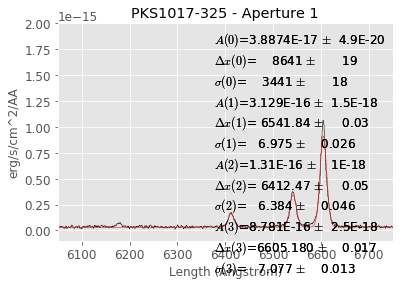

In [61]:
log.setLevel('INFO')
sp.plotter()
sp.specfit(guesses=list(guesses), fittype='gaussian')
sp.plotter.axis.set_ylim(-1e-16, 2e-15)
print(sp.specfit.parinfo)
INFO_PARINFO = copy.copy(sp.specfit.parinfo)

Param #0   AMPLITUDE0 =  6.59991e-17 +/-     4.07379e-19 
Param #1       SHIFT0 =         6178 +/-               0 
Param #2       WIDTH0 =           15 +/-               0   Range:   [0,inf)
Param #3   AMPLITUDE1 =  1.82885e-16 +/-      5.9681e-19 
Param #4       SHIFT1 =         6541 +/-               0 
Param #5       WIDTH1 =           15 +/-               0   Range:   [0,inf)
Param #6   AMPLITUDE2 =  1.07727e-16 +/-     4.46191e-19 
Param #7       SHIFT2 =         6410 +/-               0 
Param #8       WIDTH2 =           15 +/-               0   Range:   [0,inf)
Param #9   AMPLITUDE3 =  3.41269e-16 +/-     8.08949e-19 
Param #10       SHIFT3 =         6605 +/-               0 
Param #11       WIDTH3 =           15 +/-               0   Range:   [0,inf)


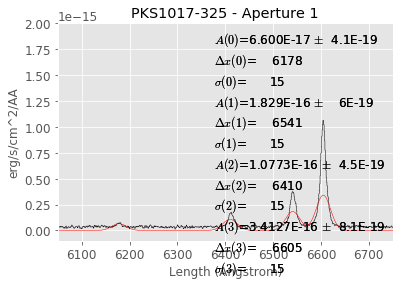

In [58]:
log.setLevel('INFO')
sp.plotter()
sp.specfit(guesses=list(guesses), fittype='gaussian', renormalize=False)
sp.plotter.axis.set_ylim(-1e-16, 2e-15)
print(sp.specfit.parinfo)
NORENORM_INFO_PARINFO = copy.copy(sp.specfit.parinfo)

In [53]:
from astropy import log
import copy
log.setLevel('DEBUG')
sp.specfit(guesses=list(guesses), fittype='gaussian')
print(sp.specfit.parinfo)
DEBUG_PARINFO = copy.copy(sp.specfit.parinfo)

DEBUG: Exclude: None [pyspeckit.spectrum.interactive]
DEBUG: Additional keyword arguments passed to fitter are: {'fittype': 'gaussian'} [pyspeckit.spectrum.fitters]
DEBUG: Parvalues = [1e-16, 6178, 15, 1e-16, 6541, 15, 1e-16, 6410, 15, 1e-16, 6605, 15], npeaks = 4.0 [pyspeckit.spectrum.models.model]
DEBUG: After VHEIGHT parse len(parinfo): 0   vheight: False [pyspeckit.spectrum.models.model]
DEBUG: After Generation step len(parinfo): 12   vheight: False parinfo: [{'error': 0.0, 'n': 0, 'limited': (False, False), 'value': 1e-16, 'parname': 'AMPLITUDE0', 'step': False, 'limits': (0, 0), 'tied': '', 'fixed': False}, {'error': 0.0, 'n': 1, 'limited': (False, False), 'value': 6178.0, 'parname': 'SHIFT0', 'step': False, 'limits': (0, 0), 'tied': '', 'fixed': False}, {'error': 0.0, 'n': 2, 'limited': (True, False), 'value': 15.0, 'parname': 'WIDTH0', 'step': False, 'limits': (0, 0), 'tied': '', 'fixed': False}, {'error': 0.0, 'n': 3, 'limited': (False, False), 'value': 1e-16, 'parname': 'AMPL

In [59]:
from astropy import log
import copy
log.setLevel(5)
sp.specfit(guesses=list(guesses), fittype='gaussian')
print(sp.specfit.parinfo)
DEBUG5_PARINFO = copy.copy(sp.specfit.parinfo)

DEBUG: Exclude: None [pyspeckit.spectrum.interactive]
DEBUG: Additional keyword arguments passed to fitter are: {'fittype': 'gaussian'} [pyspeckit.spectrum.fitters]
DEBUG: Parvalues = [1e-16, 6178, 15, 1e-16, 6541, 15, 1e-16, 6410, 15, 1e-16, 6605, 15], npeaks = 4.0 [pyspeckit.spectrum.models.model]
DEBUG: After VHEIGHT parse len(parinfo): 0   vheight: False [pyspeckit.spectrum.models.model]
DEBUG: After Generation step len(parinfo): 12   vheight: False parinfo: [{'error': 0.0, 'n': 0, 'limited': (False, False), 'value': 1e-16, 'parname': 'AMPLITUDE0', 'step': False, 'limits': (0, 0), 'tied': '', 'fixed': False}, {'error': 0.0, 'n': 1, 'limited': (False, False), 'value': 6178.0, 'parname': 'SHIFT0', 'step': False, 'limits': (0, 0), 'tied': '', 'fixed': False}, {'error': 0.0, 'n': 2, 'limited': (True, False), 'value': 15.0, 'parname': 'WIDTH0', 'step': False, 'limits': (0, 0), 'tied': '', 'fixed': False}, {'error': 0.0, 'n': 3, 'limited': (False, False), 'value': 1e-16, 'parname': 'AMPL

In [60]:
DEBUG_PARINFO, INFO_PARINFO, DEBUG5_PARINFO

([Param #0   AMPLITUDE0 =  3.80663e-17 +/-     1.09445e-19 ,
  Param #1       SHIFT0 =      6591.89 +/-         23.8419 ,
  Param #2       WIDTH0 =      1052.65 +/-         64.1608   Range:   [0,inf),
  Param #3   AMPLITUDE1 =  3.13671e-16 +/-     1.55102e-18 ,
  Param #4       SHIFT1 =      6541.83 +/-       0.0302617 ,
  Param #5       WIDTH1 =      6.65945 +/-       0.0263973   Range:   [0,inf),
  Param #6   AMPLITUDE2 =  1.28885e-16 +/-     1.09667e-18 ,
  Param #7       SHIFT2 =      6412.45 +/-       0.0503448 ,
  Param #8       WIDTH2 =      5.84873 +/-       0.0471315   Range:   [0,inf),
  Param #9   AMPLITUDE3 =  8.82511e-16 +/-     2.56806e-18 ,
  Param #10       SHIFT3 =      6605.17 +/-       0.0166405 ,
  Param #11       WIDTH3 =      6.94114 +/-       0.0134979   Range:   [0,inf)],
 [Param #0   AMPLITUDE0 =  3.88743e-17 +/-     4.91063e-20 ,
  Param #1       SHIFT0 =      8641.02 +/-         19.3876 ,
  Param #2       WIDTH0 =      3440.59 +/-         18.1573   Range:   [

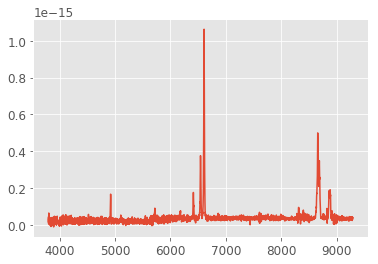

In [34]:
import pylab as pl
pl.plot(sp.xarr, sp.specfit.spectofit)

In [35]:
sp.error

masked_array(data = [  3.82400179e-18   4.39784800e-18   4.39897586e-18 ...,   2.48575260e-18
   2.34658753e-18   2.28623602e-18],
             mask = False,
       fill_value = 1e+20)

INFO: Renormalizing data by factor 3.248316e-17 to improve fitting procedure [pyspeckit.spectrum.fitters]
Param #0   AMPLITUDE0 =  3.88743e-17 +/-     4.91062e-20 
Param #1       SHIFT0 =      8641.02 +/-         19.3875 
Param #2       WIDTH0 =      3440.59 +/-         18.1573   Range:   [0,inf)
Param #3   AMPLITUDE1 =  8.78128e-16 +/-     2.53426e-18 
Param #4       SHIFT1 =      6605.18 +/-       0.0165556 
Param #5       WIDTH1 =      7.07738 +/-       0.0133443   Range:   [0,inf)
Param #6   AMPLITUDE2 =   3.1287e-16 +/-     1.50807e-18 
Param #7       SHIFT2 =      6541.84 +/-       0.0301744 
Param #8       WIDTH2 =      6.97481 +/-       0.0261652   Range:   [0,inf)
Param #9   AMPLITUDE3 =  1.31166e-16 +/-     1.04137e-18 
Param #10       SHIFT3 =      6412.47 +/-       0.0502355 
Param #11       WIDTH3 =      6.38373 +/-       0.0463755   Range:   [0,inf)


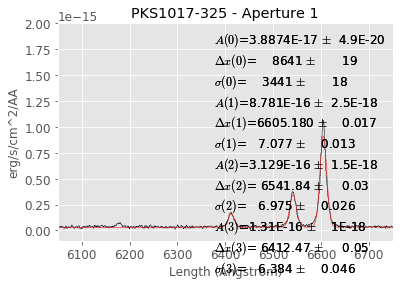

In [36]:
sp.plotter()
sp.specfit(guesses=list(guesses), fittype='gaussian')
sp.plotter.axis.set_ylim(-1e-16, 2e-15)
print(sp.specfit.parinfo)

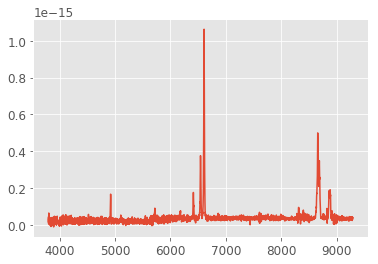

In [37]:
import pylab as pl
pl.plot(sp.xarr, sp.specfit.spectofit)

In [38]:
log.setLevel("INFO")

NameError: name 'log' is not defined

In [ ]:
sp.plotter(xmin=6050, xmax=6750, errstyle='fill')
sp.specfit.plot_fit(annotate=False, lw=2.0)
sp.specfit.plot_components(add_baseline=True,component_yoffset=+0.0)
sp.specfit.plotresiduals(axis=sp.plotter.axis,clear=False,yoffset=0.0,label=False, color='orange')
sp.plotter.axis.set_ylim(-1e-16, 2e-15)

In [ ]:
sp.specfit.highlight_fitregion()
sp.plotter(xmin=6050, xmax=6750, errstyle='fill')

In [ ]:
sp.specfit.print_fit()

In [ ]:
guesses

In [ ]:
sp.plotter()
sp.specfit.selectregion(fit_plotted_area=True)
sp.specfit.multifit(guesses=list(guesses))
sp.specfit.print_fit()